In [2]:
import wellmap
import pandas as pd
import os
import string
import seaborn as sns
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

New for multiple images in CP file

In [40]:
part_to_folder = r"C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-07-24 Vero Rd hTERT CK-99c ISK-1 + CK-122 Slovesnova\0H plates CK-122"

# files = [f for f in listdir(part_to_folder) if isfile(join(part_to_folder, f))]

image_list_path = os.path.join(part_to_folder, "ExpImage.csv")
data_path  = os.path.join(part_to_folder, "ExpWells_plate.csv")

data_raw_df = pd.read_csv(data_path) 
image_list_df = pd.read_csv(image_list_path) 

print(image_list_df)


                                 FileName_RGB  ImageNumber
0  2024-07-19 RD CK-122 0H (Multichannel).tif            1
1  2024-07-19 RD CK-122 5H (Multichannel).tif            2


Extract wellmaps and combine into one df with names of the images

C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-07-24 Vero Rd hTERT CK-99c ISK-1 + CK-122 Slovesnova\0H plates CK-122\2024-07-19 RD CK-122 0H (Multichannel).toml


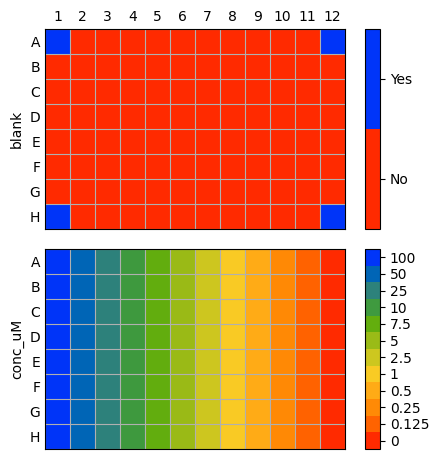

In [41]:
wellmap_path_list = []

for file in os.listdir(part_to_folder):
    if file.endswith(".toml"):
        wellmap_path_list.append(os.path.join(part_to_folder, file))
        # wellmap_path_list.append(file)

print(wellmap_path_list[0])

wellmap_df = wellmap.load(wellmap_path_list[0]) 

wellmap_list = []

for file in wellmap_path_list:
    wellmap_i = wellmap.load(file)
    wellmap_list.append(wellmap_i)

wellmaps_df = pd.concat(wellmap_list, axis=0, ignore_index=True)
# print(wellmaps_df)

wellmap.show(file);
plt.show();

Generating labels for wells

In [42]:
# row_column_df = pd.DataFrame(columns=['row','col'])

row =  list(string.ascii_uppercase[0:8])
column = list(range(1,13))
plate = image_list_df['FileName_RGB'].to_list()

row_column_list = []


for p in plate:
    for c in column:
        for r in row:
            array_i = [r,c]
            row_column_list.append(array_i)

row_column_df = pd.DataFrame(row_column_list, columns = ['row', 'col']) 

print(row_column_df)

    row  col
0     A    1
1     B    1
2     C    1
3     D    1
4     E    1
..   ..  ...
187   D   12
188   E   12
189   F   12
190   G   12
191   H   12

[192 rows x 2 columns]


Add images names to data (thank you CellProfiler for convenience)

In [43]:
data_full_df =  pd.merge(data_raw_df, image_list_df, on='ImageNumber') #Data with image names (FileName_RGB)
data_indexed = pd.concat([row_column_df, data_full_df], axis=1, join='inner') #Data with image names (FileName_RGB) and cell indexes (row,col)

data_indexed['col']=data_indexed['col'].astype(str) #Otherwise everything will break

data_plate = pd.merge(data_indexed, wellmaps_df, on=['FileName_RGB','row','col']) #Data with image names (FileName_RGB), cell indexes and wellmap
data_plate[["conc_uM"]] = data_plate[["conc_uM"]].apply(pd.to_numeric)

print(data_plate)

    row col  ImageNumber  ObjectNumber  \
0     A   1            1             1   
1     B   1            1             2   
2     C   1            1             3   
3     D   1            1             4   
4     E   1            1             5   
..   ..  ..          ...           ...   
187   D  12            2            92   
188   E  12            2            93   
189   F  12            2            94   
190   G  12            2            95   
191   H  12            2            96   

     Intensity_IntegratedIntensity_OrigGreen  \
0                                  61.529414   
1                                  62.172551   
2                                  67.705885   
3                                  60.584316   
4                                  63.050982   
..                                       ...   
187                               944.066692   
188                               889.921595   
189                               919.776495   
190            

0H plate as a reference plate

0     1198.701988
1     1254.231399
2     1405.733370
3     1214.203948
4     1278.125518
         ...     
91    1352.505916
92    1355.721604
93    1416.913766
94    1288.690227
95    1475.411811
Name: Intensity_IntegratedIntensity_OrigRed, Length: 96, dtype: float64


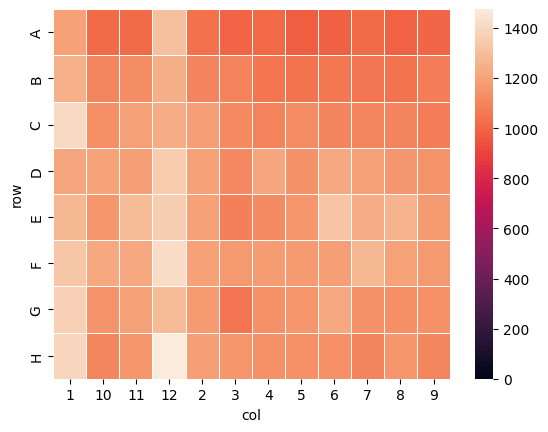

In [44]:
reference_plate = data_plate[(data_plate['RZ_incubation'] == '0H')].copy()

# print(reference_plate)

heatmap_df = reference_plate.pivot(index="row", columns="col", values="Intensity_IntegratedIntensity_OrigRed")

sns.heatmap(heatmap_df, linewidth=.5, vmin=0, vmax=None)

print(reference_plate['Intensity_IntegratedIntensity_OrigRed'])

0.21134980297481407
0     1.030272
1     1.077999
2     1.208214
3     1.043596
4     1.098536
        ...   
91    1.162465
92    1.165229
93    1.217823
94    1.107616
95    1.268102
Name: Mean_dif, Length: 96, dtype: float64


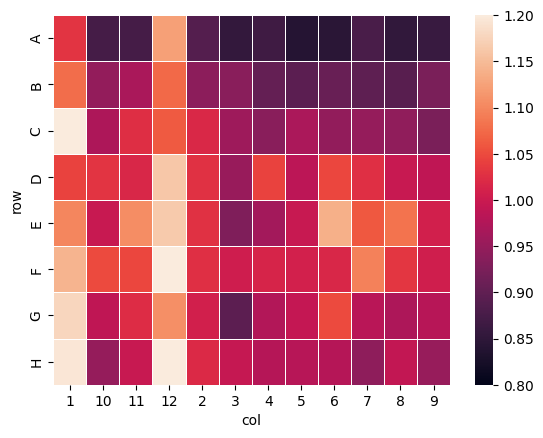

In [59]:
# mean_array_reference_plate = []

# for p in plate:
#     mean = reference_plate[(reference_plate['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigRed'].mean()
#     print(mean)

#     bc_array_i = [mean,p]

#     mean_array_reference_plate.append(bc_array_i)


# mean_reference_plate = pd.DataFrame(reference_plate, columns = ['mean','FileName_RGB']) 
p = "2024-07-19 RD CK-122 0H (Multichannel).tif"

mean = reference_plate[(reference_plate['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigRed'].mean()

print(mean)

reference_plate['Mean_dif'] = reference_plate['Intensity_MeanIntensity_OrigRed']/mean

reference_plate['Mean_corr'] = reference_plate['Intensity_MeanIntensity_OrigRed']/reference_plate['Mean_dif'] 

print(reference_plate['Mean_dif'])

heatmap_df = reference_plate.pivot(index="row", columns="col", values="Mean_dif")

sns.heatmap(heatmap_df, linewidth=.5, vmax=1.2, vmin=0.80 )


plt.show()


   row col  ImageNumber  ObjectNumber  \
0    A   1            2             1   
1    B   1            2             2   
2    C   1            2             3   
3    D   1            2             4   
4    E   1            2             5   
..  ..  ..          ...           ...   
91   D  12            2            92   
92   E  12            2            93   
93   F  12            2            94   
94   G  12            2            95   
95   H  12            2            96   

    Intensity_IntegratedIntensity_OrigGreen  \
0                                 77.466670   
1                                 92.788239   
2                                189.564713   
3                                 98.427455   
4                                 94.607847   
..                                      ...   
91                               944.066692   
92                               889.921595   
93                               919.776495   
94                               748.

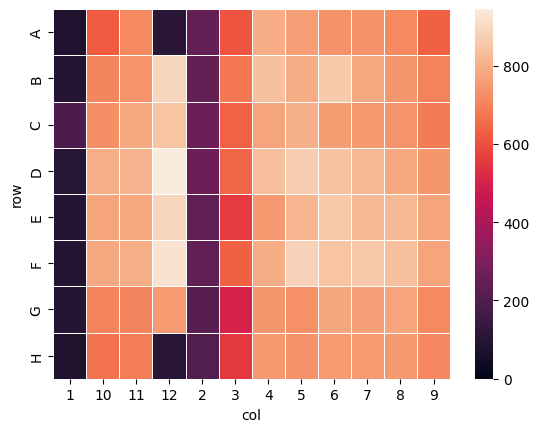

In [60]:
sample_plate = data_plate[(data_plate['RZ_incubation'] == '5H')].copy().reset_index(drop=True)

heatmap_df = sample_plate.pivot(index="row", columns="col", values="Intensity_IntegratedIntensity_OrigGreen")

sns.heatmap(heatmap_df, linewidth=.5, vmin=0, vmax=None)

print(sample_plate)

0     0.014604
1     0.018303
2     0.041909
3     0.018796
4     0.019017
        ...   
91    0.200813
92    0.189746
93    0.204963
94    0.151766
95    0.023248
Name: Mean_corr, Length: 96, dtype: float64


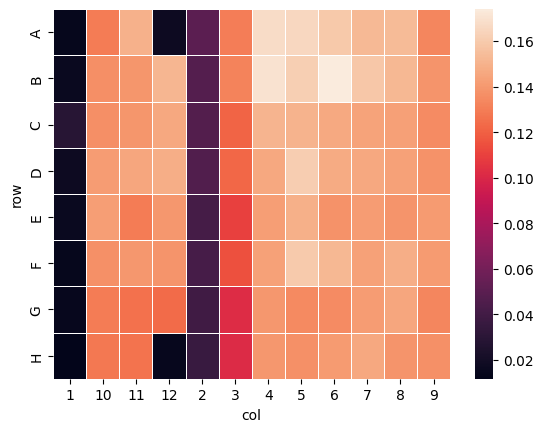

In [67]:
sample_plate['Mean_dif'] = reference_plate['Mean_dif']

sample_plate['Mean_corr'] = sample_plate['Intensity_MeanIntensity_OrigGreen']*sample_plate['Mean_dif']

print(sample_plate['Mean_corr'])

heatmap_df = sample_plate.pivot(index="row", columns="col", values="Mean_corr")

# sns.heatmap(heatmap_df, linewidth=.5, vmin=0, vmax=None)

p = "2024-07-19 RD CK-122 5H (Multichannel).tif"

mean_sample = sample_plate[(sample_plate['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()

sample_plate['Mean_dif_to_mean'] = sample_plate['Intensity_MeanIntensity_OrigGreen']/mean_sample

sample_plate['Mean_dif_to_mean'] = sample_plate['Intensity_MeanIntensity_OrigGreen']/mean_sample

sample_plate['Mean_corr'] = sample_plate['Intensity_MeanIntensity_OrigGreen']/reference_plate['Mean_dif'] 

sample_plate['Mean_corr_dif'] = sample_plate['Mean_corr']/mean_sample


heatmap_df = sample_plate.pivot(index="row", columns="col", values="Mean_corr")

sns.heatmap(heatmap_df, linewidth=.5 )


plt.show()


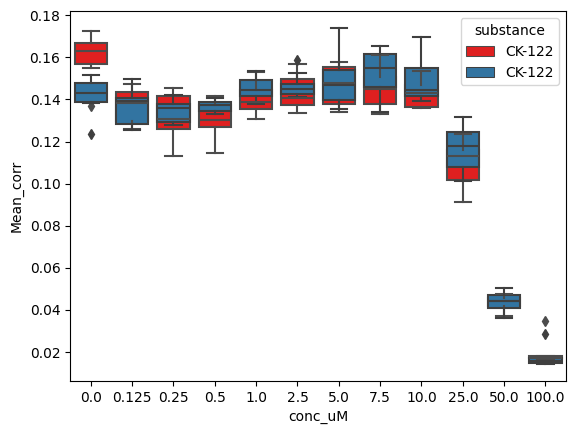

In [161]:
# row_drop_list = ['A','H']

# cleared_data = sample_plate[~sample_plate['row'].isin(row_drop_list)]

cleared_data = sample_plate[sample_plate['blank']=='No']

well_drop_list = ['']

ax = sns.boxplot(data=cleared_data, x="conc_uM", y="Intensity_MeanIntensity_OrigGreen", hue = 'substance', palette=['r'])

ay = sns.boxplot(data=cleared_data, x="conc_uM", y="Mean_corr", hue = 'substance')

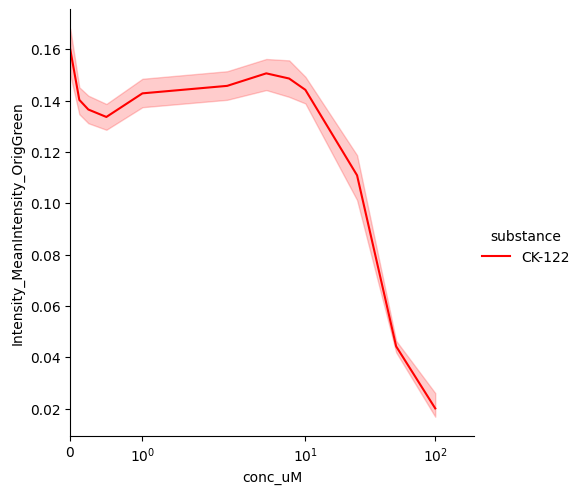

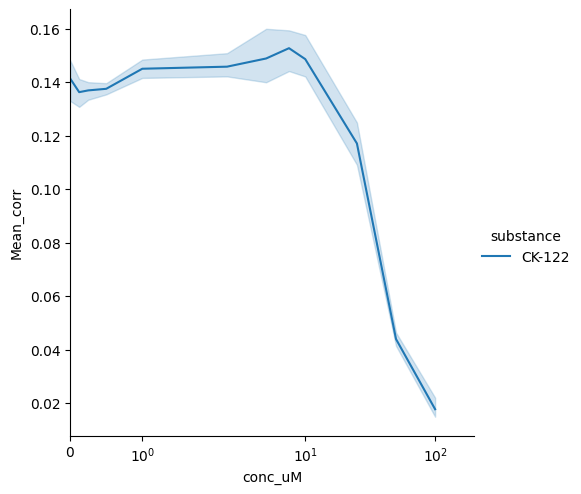

In [160]:

ax = sns.relplot(data=cleared_data, x="conc_uM", y="Intensity_MeanIntensity_OrigGreen", hue = 'substance', palette=['r'],  kind="line")

ay = sns.relplot(data=cleared_data, x="conc_uM", y="Mean_corr", hue = 'substance',  kind="line")

ax.set(xscale="symlog")
ay.set(xscale="symlog")

ax.set(xlim=(0, 200))
ay.set(xlim=(0, 200))

Blank and control calculation for each plate

In [127]:
blank_array = []

p = "2024-07-19 RD CK-122 5H (Multichannel).tif"



blank_p = sample_plate[(sample_plate['blank'] == 'Yes') & (sample_plate['FileName_RGB'] == p)].loc[:,'Mean_corr'].mean()
blank_std_p = sample_plate[(sample_plate['blank'] == 'Yes') & (sample_plate['FileName_RGB'] == p)].loc[:,'Mean_corr'].std()

bc_array_i = [blank_p, blank_std_p ,p]

blank_array.append(bc_array_i)

blank_df = pd.DataFrame(blank_array, columns = ['blank_mean','blank_std','FileName_RGB']) 

data_plate_with_blank = pd.merge(sample_plate, blank_df, on=['FileName_RGB'])

print(blank_df)


   blank_mean  blank_std                                FileName_RGB
0    0.014342   0.002316  2024-07-19 RD CK-122 5H (Multichannel).tif


In [151]:
data_plate_with_blank['Green_blanked'] = data_plate_with_blank['Mean_corr'] - data_plate_with_blank['blank_mean']


data_plate_wo_blank = data_plate_with_blank[data_plate_with_blank.blank == 'No'].copy() #dataframe without blank

control_array = []

control_p = data_plate_wo_blank[(data_plate_wo_blank['control'] == 'Yes') 
                                & (data_plate_wo_blank['blank'] == 'No') & 
                                (data_plate_wo_blank['FileName_RGB'] == p)].loc[:,'Green_blanked'].mean()

control_std_p = data_plate_wo_blank[(data_plate_wo_blank['control'] == 'Yes') 
                                    & (data_plate_wo_blank['blank'] == 'No') & 
                                    (data_plate_wo_blank['FileName_RGB'] == p)].loc[:,'Green_blanked'].std()

bc_array_i = [control_p,control_std_p,p]

control_array.append(bc_array_i)

control_df = pd.DataFrame(control_array, columns = ['control_mean', 'control_std','FileName_RGB']) 

print(control_df)

data_plate_with_control = pd.merge(data_plate_wo_blank, control_df, on=['FileName_RGB'])

data_plate_with_control['Green_relative'] = data_plate_with_control['Green_blanked']/data_plate_with_control['control_mean']*100


print(data_plate_with_control[(data_plate_with_control['control'] == 'Yes') 
                                & (data_plate_with_control['blank'] == 'No') & 
                                (data_plate_with_control['FileName_RGB'] == p)].loc[:,'Green_relative'])

   control_mean  control_std                                FileName_RGB
0      0.126975     0.010039  2024-07-19 RD CK-122 5H (Multichannel).tif
86    108.129786
87    103.689778
88    105.739179
89     98.765228
90     97.544882
91     86.131147
Name: Green_relative, dtype: float64


Plotting


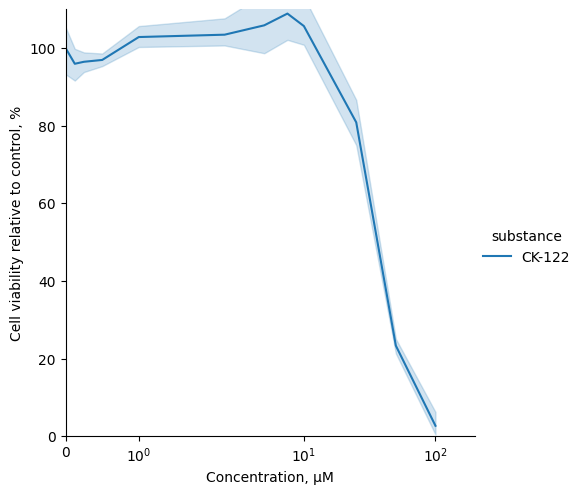

In [154]:

row_drop_list = ['A','H']

cleared_data = data_plate_with_control[~data_plate_with_control['row'].isin(row_drop_list)]

ax = sns.relplot(data=cleared_data, x="conc_uM", y="Green_relative", kind="line", hue = 'substance')

# ax.set(xlabel=None, ylabel='Viable cell, % of control')

ax.set(xlabel='Concentration, μM', ylabel='Cell viability relative to control, %')
ax.set(xscale="symlog")

ax.set(xlim=(0, 200),ylim = (0,110))

plt.show()



<Axes: xlabel='control', ylabel='Green_relative'>

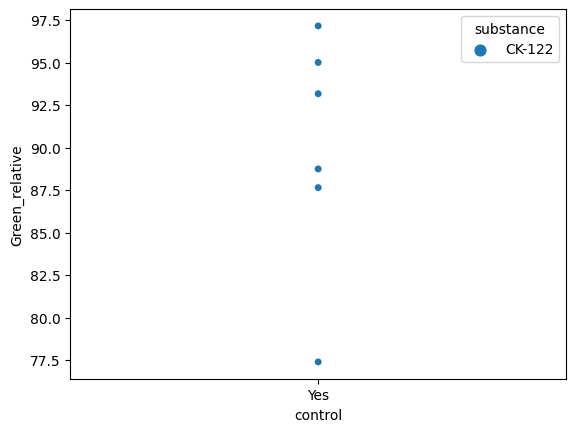

In [119]:
sns.swarmplot(data=data_plate_with_control, x="control", y="Green_relative", hue = 'substance')

In [ ]:
ax = sns.stripplot(data=data_plate_with_mean_blank_control, x="row", y="Intensity_MeanIntensity_OrigRed", hue = 'substance')
# ax.set(xscale="symlog")
# ax.set(xlim=(-1, 110))

ax.set(ylim = (0,None))
plt.show()


In [ ]:
ax = sns.relplot(data=data_plate_with_mean_blank_control, x="conc_uM", y="Green_relative", kind="line", 
                 hue = 'substance', col='cells', ci=None)

ax.set(xlabel='Concentration, μM', ylabel='Cell viability relative to control, %')
ax.set(xscale="symlog")

ax.set(xlim=(0, 200),ylim = (0,100))

plt.show()

In [ ]:
# ax = sns.heatmap(data=data_selected)
# ax.set(xscale="symlog")
# ax.set(xlim=(-1, 110))

# ax.set(ylim = (0,None))

data_selected = data_plate[(data_plate['substance'] == 'Test 3')].copy()

heatmap_df = data_selected.pivot(index="row", columns="col", values="Intensity_IntegratedIntensity_OrigGreen")

# print(heatmap_df)

sns.heatmap(heatmap_df, linewidth=.5, vmin=0, vmax=None)

plt.show()

In [ ]:
row_drop_list = ['A','H']

data_plate_edges_drop = data_plate[~data_plate['row'].isin(row_drop_list)]



In [ ]:
blank_control_array_ED = []

for p in plate:
    mean = data_plate_edges_drop[(data_plate_edges_drop['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()

    bc_array_i = [mean,p]

    blank_control_array_ED.append(bc_array_i)


blank_control_df_ED = pd.DataFrame(blank_control_array_ED, columns = ['mean','FileName_RGB']) 

print(blank_control_df_ED)

In [ ]:
DPE_with_mean_blank_control = pd.merge(data_plate_edges_drop, blank_control_df_ED, on=['FileName_RGB'])

DPE_with_mean_blank_control['Mean_dif'] = DPE_with_mean_blank_control['Intensity_MeanIntensity_OrigGreen']/DPE_with_mean_blank_control['mean']

DPE_with_mean_blank_control['Mean_corr'] = DPE_with_mean_blank_control['Intensity_MeanIntensity_OrigGreen']/DPE_with_mean_blank_control['Mean_dif'] 

print(DPE_with_mean_blank_control['Mean_corr'])

In [ ]:
ax = sns.stripplot(data=DPE_with_mean_blank_control, x="col", y="Mean_corr", hue = 'substance')
# ax.set(xscale="symlog")
# ax.set(xlim=(-1, 110))

ax.set(ylim = (0,None))
plt.show()


In [ ]:
path_to_folder_2 = r"C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-07-24 Vero Rd hTERT CK-99c ISK-1 + CK-122 Slovesnova"

# files = [f for f in listdir(part_to_folder) if isfile(join(part_to_folder, f))]

image_list_path_2 = os.path.join(path_to_folder_2, "ExpImage.csv")
data_path_2  = os.path.join(path_to_folder_2, "ExpWells_plate.csv")

data_raw_df_2 = pd.read_csv(data_path_2) 
image_list_df_2 = pd.read_csv(image_list_path_2) 

print(image_list_df_2)


In [ ]:
wellmap_path_list_2 = []

for file in os.listdir(path_to_folder_2):
    if file.endswith(".toml"):
        wellmap_path_list_2.append(os.path.join(path_to_folder_2, file))
        # wellmap_path_list.append(file)

# print(wellmap_path_list[0])

wellmap_df = wellmap.load(wellmap_path_list[0]) 

wellmap_list = []

for file in wellmap_path_list_2:
    wellmap_i = wellmap.load(file)
    wellmap_list.append(wellmap_i)

wellmaps_df_2 = pd.concat(wellmap_list, axis=0, ignore_index=True)
# print(wellmaps_df)

wellmap.show(file);
plt.show();

In [ ]:
# row_column_df = pd.DataFrame(columns=['row','col'])

row =  list(string.ascii_uppercase[0:8])
column = list(range(1,13))
plate = image_list_df_2['FileName_RGB'].to_list()

row_column_list = []


for p in plate:
    for c in column:
        for r in row:
            array_i = [r,c]
            row_column_list.append(array_i)

row_column_df_2 = pd.DataFrame(row_column_list, columns = ['row', 'col']) 

print(row_column_df_2)

In [ ]:
data_full_df_2 =  pd.merge(data_raw_df_2, image_list_df_2, on='ImageNumber') #Data with image names (FileName_RGB)
data_indexed_2 = pd.concat([row_column_df_2, data_full_df_2], axis=1, join='inner') #Data with image names (FileName_RGB) and cell indexes (row,col)

data_indexed_2['col']=data_indexed_2['col'].astype(str) #Otherwise everything will break

data_plate_2 = pd.merge(data_indexed_2, wellmaps_df_2, on=['FileName_RGB','row','col']) #Data with image names (FileName_RGB), cell indexes and wellmap
data_plate_2[["conc_uM"]] = data_plate_2[["conc_uM"]].apply(pd.to_numeric)

print(data_plate_2.columns)

In [ ]:
data_extracted = data_plate_2[(data_plate_2['FileName_RGB'] == '2024-07-19 Vero CK-122 5H (Multichannel).tif')]

data_extracted['Mean_corr'] = data_extracted['Intensity_MeanIntensity_OrigGreen']/DPE_with_mean_blank_control['Mean_dif']

print(DPE_with_mean_blank_control['Mean_dif'])


#Надо попробовать сделать опорным 0_H планшет

In [ ]:
ax = sns.stripplot(data=data_extracted, x="row", y="Intensity_MeanIntensity_OrigGreen", hue = 'substance')
# ax.set(xscale="symlog")
# ax.set(xlim=(-1, 110))

ax.set(ylim = (0,None))
plt.show()



In [ ]:
ax = sns.stripplot(data=data_extracted, x="row", y="Mean_corr", hue = 'substance')
# ax.set(xscale="symlog")
# ax.set(xlim=(-1, 110))

ax.set(ylim = (0,None))
plt.show()
